In [1]:
!pip install pgvector --quiet

In [2]:
!pip install psycopg --quiet

In [ ]:
!pip install rasterio --quiet

In [ ]:
!pip install earthpy --quiet

In [127]:
!pip install folium matplotlib mapclassify --quiet

In [150]:
import torch
import numpy
import pandas as pd
import geopandas as gpd
import numpy as np
import psycopg
from pgvector.psycopg import register_vector
import rasterio
import earthpy.plot as ep
from earthpy.io import path_to_example
from shapely import wkt

In [ ]:
!curl ipecho.net/plain

In [5]:
conn = psycopg.connect(
    host="",
    user="",
    password="",
    dbname="",
    port=5432,
    autocommit=True,
)
register_vector(conn)

In [6]:
image_names = pd.read_csv("/content/drive/MyDrive/ben_testset/bigearthnet-test.csv", header=None)
image_names.columns = ["s2name", "s1name"]


In [7]:
image_names["url"] = "https://ryans-website-thing-public.s3.us-west-2.amazonaws.com/bigearthnet/" + image_names["s2name"] + "_RGB.tif"

In [8]:
image_urls = image_names["url"]

In [9]:
image_urls

0         https://ryans-website-thing-public.s3.us-west-...
1         https://ryans-website-thing-public.s3.us-west-...
2         https://ryans-website-thing-public.s3.us-west-...
3         https://ryans-website-thing-public.s3.us-west-...
4         https://ryans-website-thing-public.s3.us-west-...
                                ...                        
125861    https://ryans-website-thing-public.s3.us-west-...
125862    https://ryans-website-thing-public.s3.us-west-...
125863    https://ryans-website-thing-public.s3.us-west-...
125864    https://ryans-website-thing-public.s3.us-west-...
125865    https://ryans-website-thing-public.s3.us-west-...
Name: url, Length: 125866, dtype: object

In [10]:
geoms = gpd.read_file("/content/drive/MyDrive/ben_testset/BEN_geoms.gpkg")

In [11]:
geoms = geoms.to_wkt()

In [12]:
embeddings = torch.load("/content/drive/MyDrive/ben_testset/embeddings.pt")

In [13]:
embeddings_df = pd.DataFrame(embeddings)

In [14]:
big_gdf = pd.concat([embeddings_df, image_urls, geoms], axis=1)

In [31]:
conn.execute('DROP TABLE IF EXISTS bigearthnet_testset')
conn.execute('CREATE TABLE bigearthnet_testset ( id bigserial PRIMARY KEY, embedding vector(768), url text, geom geometry(MultiPolygon, 4326) )')

<psycopg.Cursor [COMMAND_OK] [IDLE] (host=database-1.crubsescedmr.us-east-1.rds.amazonaws.com database=postgres) at 0x780bd96996f0>

In [ ]:
big_gdf[np.r_[0:768]].iloc[0].to_numpy()

In [27]:
data_list = [(row[np.r_[0:768]].to_numpy(), row["url"], row["geometry"])  for index, row in big_gdf.iterrows()]

In [38]:
with conn.cursor() as cur:
  cur.executemany('INSERT INTO bigearthnet_testset (embedding, url, geom) VALUES (%s, %s, %s)', data_list)

In [93]:
res = conn.execute("SELECT embedding, url, ST_AsText(ST_Centroid(geom)) FROM bigearthnet_testset where id =1").fetchall()
embedding_id_1 = res[0][0]
img_url_id_1 = res[0][1]
centroid_id_1 = "SRID=4326;"+res[0][2]

In [60]:
img = rasterio.open(img_url_id_1)

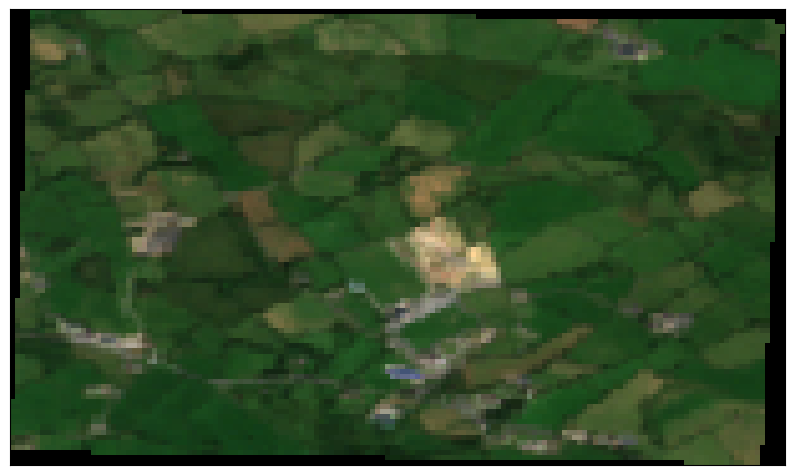

<Axes: >

In [61]:
ep.plot_rgb(img.read())
# Image 1

In [95]:
# Get nearest neighbors
res = conn.execute('SELECT id, embedding, url, ST_AsText(ST_Centroid(geom)), embedding <-> %s as l2_distance, ST_Distance(%s, ST_Centroid(geom)) as distance FROM bigearthnet_testset ORDER BY l2_distance LIMIT 6', (embedding_id_1, centroid_id_1)).fetchall()[1:]

In [111]:
print(f"Neighbor ID: {res[0][0]}")
img = rasterio.open(res[0][2])
print(f"Centroid: {res[0][3]}")
print(f"L2 Distance: {res[0][4]}")
print(f"Physical Distance: {res[0][5]}")


Neighbor ID: 6338
Centroid: POINT(-7.0249125 52.85027850000001)
L2 Distance: 0.6911999885099352
Physical Distance: 1.2271401083173048


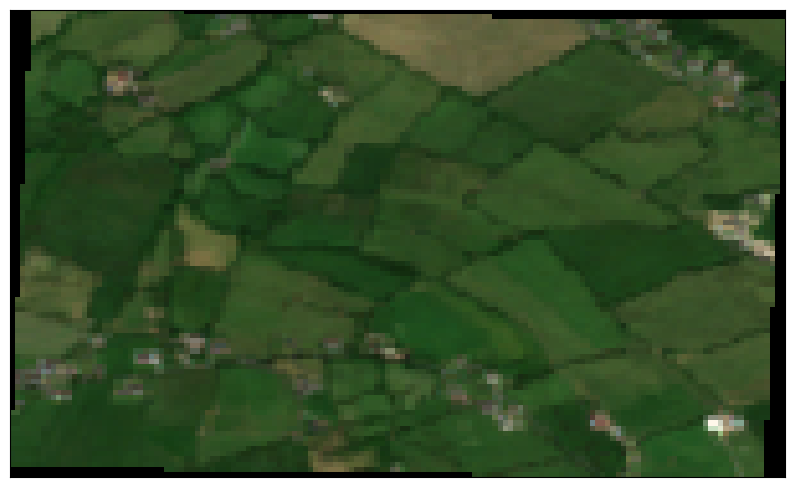

<Axes: >

In [101]:
ep.plot_rgb(img.read())

In [112]:
print(f"Neighbor ID: {res[1][0]}")
img = rasterio.open(res[1][2])
print(f"Centroid: {res[1][3]}")
print(f"L2 Distance: {res[1][4]}")
print(f"Physical Distance: {res[1][5]}")


Neighbor ID: 7042
Centroid: POINT(-6.490390499999999 52.538006)
L2 Distance: 0.8090295032124455
Physical Distance: 1.6039662425242238


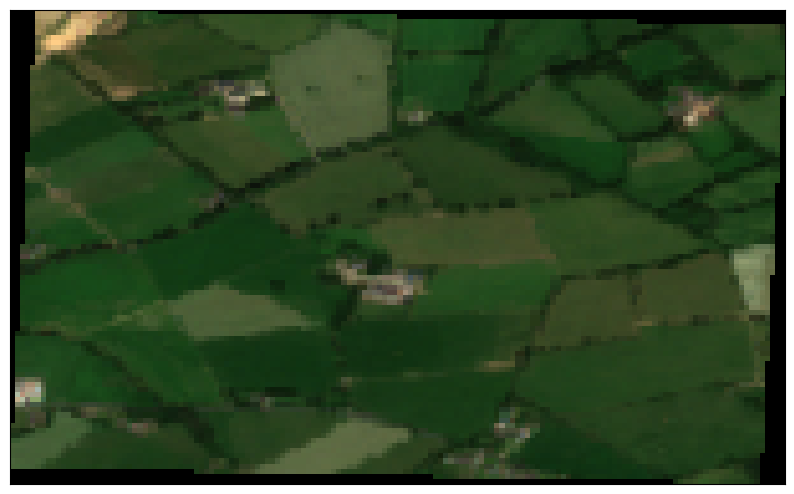

<Axes: >

In [104]:
ep.plot_rgb(img.read())

In [113]:
print(f"Neighbor ID: {res[2][0]}")
img = rasterio.open(res[2][2])
print(f"Centroid: {res[2][3]}")
print(f"L2 Distance: {res[2][4]}")
print(f"Physical Distance: {res[2][5]}")


Neighbor ID: 5863
Centroid: POINT(-7.426483 52.586538000000004)
L2 Distance: 0.8723471139237942
Physical Distance: 1.5632769049156072


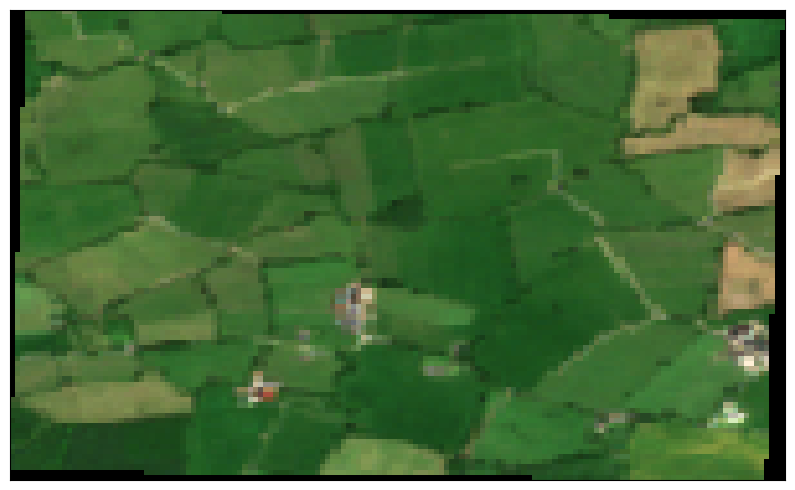

<Axes: >

In [106]:
ep.plot_rgb(img.read())

In [114]:
print(f"Neighbor ID: {res[3][0]}")
img = rasterio.open(res[3][2])
print(f"Centroid: {res[3][3]}")
print(f"L2 Distance: {res[3][4]}")
print(f"Physical Distance: {res[3][5]}")


Neighbor ID: 7222
Centroid: POINT(-6.34376 52.6211425)
L2 Distance: 0.9185058321199194
Physical Distance: 1.5748001005519052


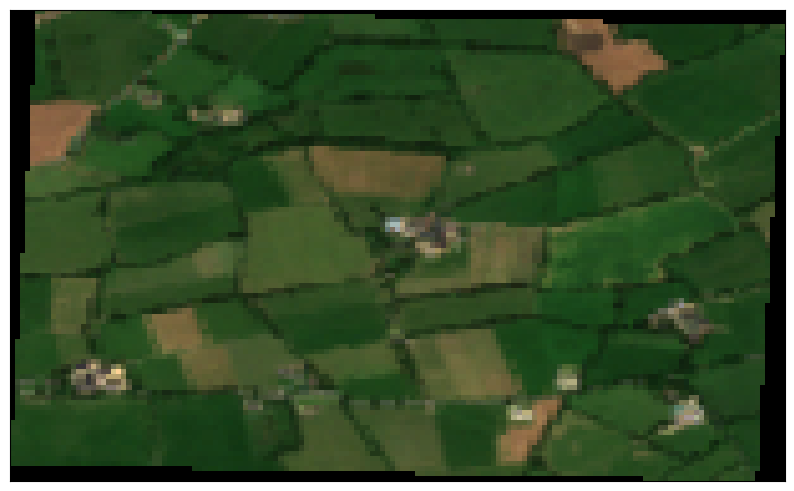

<Axes: >

In [109]:
ep.plot_rgb(img.read())

In [116]:
print(f"Neighbor ID: {res[4][0]}")
img = rasterio.open(res[4][2])
print(f"Centroid: {res[4][3]}")
print(f"L2 Distance: {res[4][4]}")
print(f"Physical Distance: {res[4][5]}")


Neighbor ID: 27
Centroid: POINT(-6.818885000000001 54.105146)
L2 Distance: 0.9489238265149801
Physical Distance: 0.13339396368838832


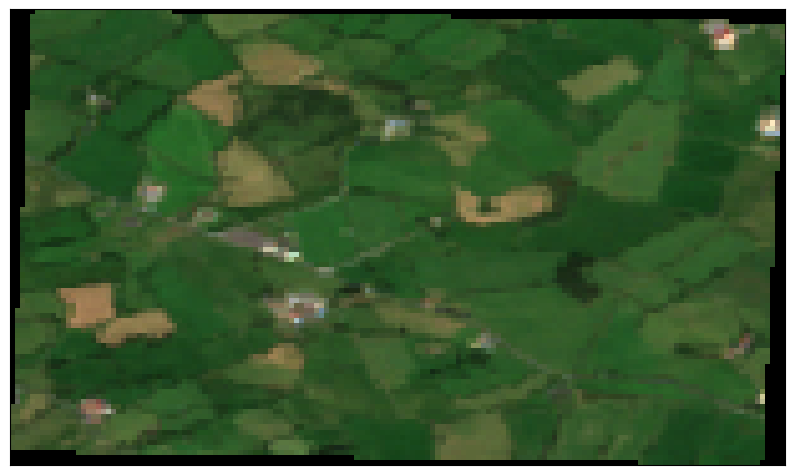

<Axes: >

In [117]:
ep.plot_rgb(img.read())

Well, these are all Irish fields with buildings on them. Spot on, as was discussed in the paper.

In [146]:
original_centroid = conn.execute("SELECT ST_AsText(ST_Centroid(geom)) FROM bigearthnet_testset where id =1").fetchall()[0][0]
df = pd.DataFrame({
  "id":[
    1,
    res[0][0],
    res[1][0],
    res[2][0],
    res[3][0],
    res[4][0],
  ],
  "l2_disance":[
    0,
    res[0][4],
    res[1][4],
    res[2][4],
    res[3][4],
    res[4][4]
  ],
  "physical_distance":[
    0,
    res[0][5],
    res[1][5],
    res[2][5],
    res[3][5],
    res[4][5]
  ],
  "geometry":[
    original_centroid,
    res[0][3],
    res[1][3],
    res[2][3],
    res[3][3],
    res[4][3]
  ]
})

In [151]:
df["geometry"] = df["geometry"].apply(wkt.loads)

In [154]:
gdf = gpd.GeoDataFrame(df, crs="EPSG:4326")

In [155]:
gdf.explore()